In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data

df = pd.read_csv("Familly NICU.csv")
print(f'Abstract included: {len(df)}')
df.head()

Abstract included: 36


,ID,Type,Title,Journal,DOI,URL,Abstract,Authors,Year
0,http://zotero.org/users/1254356/items/98XWC6GD,article-journal,Experiences of families in the neurological IC...,The Journal of neuroscience nursing : journal ...,NaN,https://pubmed.ncbi.nlm.nih.gov/15233414/,This study explores the experiences of family ...,Lam Pikka; Beaulieu Marcia,2004.0
1,http://zotero.org/users/1254356/items/A824HT7C,article-journal,Redesigning the neurocritical care unit to enh...,Cleveland Clinic journal of medicine,10.3949/ccjm.76.s2.14,https://pubmed.ncbi.nlm.nih.gov/19376988/,Emory University Hospital recently converted i...,Samuels Owen,2009.0
2,http://zotero.org/users/1254356/items/3X6G8FNE,article-journal,Nursing case management: relationships as a st...,Clinical nurse specialist CNS,10.1097/00002800-199603000-00016,https://pubmed.ncbi.nlm.nih.gov/8705943/,"MULTIPLE TRANSFERS, MULTIPLE caregivers, and a...",Sohl-Kreiger R; Lagaard M W; Scherrer J,1996.0
3,http://zotero.org/users/1254356/items/7XBI5A2S,article-journal,Living a nightmare: family experiences of wait...,The Journal of neuroscience nursing : journal ...,10.1097/01376517-199908000-00005,https://pubmed.ncbi.nlm.nih.gov/10553571/,This study examined the waiting experiences of...,Plowfield L A,1999.0
4,http://zotero.org/users/1254356/items/AESCSSRD,article-journal,Retrospective agreement and consent to neurocr...,"Critical care (London, England)",10.1186/cc9210,https://pubmed.ncbi.nlm.nih.gov/20673358/,Only limited data are available on consent and...,Kiphuth Ines C; Köhrmann Martin; Kuramatsu Joj...,2010.0


In [4]:
print(f' Period inclusion of the article: {df["Year"].min():.0f} - {df["Year"].max():.0f}')

 Period inclusion of the article: 1996 - 2025


In [5]:
# Stop word anglais commun + adding common medical stop word.

SUPPLEMENTARY_STOP_WORDS = {
    'care', 'ICU',
    'study', 'studies', 'hospital', 'method', 'result', "admission",
    "admitted"
} 

stop_words = set(ENGLISH_STOP_WORDS).union(SUPPLEMENTARY_STOP_WORDS)

I'll do a "light" lemmatisation with nltk to reduce the vocabulary.

In [6]:
nltk.download('punkt_tab')      # Tokenisator
nltk.download('wordnet')    # Lemmatizator
nltk.download('omw-1.4')  

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pjcun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pjcun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pjcun\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:

lemmatizer = WordNetLemmatizer()

def lemmatizator(texte):
    tokens = word_tokenize(texte)
    lemmes = [lemmatizer.lemmatize(token) for token in tokens]
    return' '.join(lemmes)

for abs in df.index:
    df.loc[abs, 'Abstract_lem'] = lemmatizator(df.loc[abs, 'Abstract'])


I'll use a TF IDF methodology (Term Frequency - Inverse Document Frequency)

In [8]:
# text concersion in number matrix
vectorizer = TfidfVectorizer(
    max_features=200, # we keep only 200 hundred more frequent word
    min_df=2, # minimum occurence of a word to be included
    max_df=0.8, # word with > 80% persence are ignored
    stop_words=list(stop_words),
    ngram_range=(1, 3), # range of n-gram analysed
    token_pattern=r'\b[a-zA-Z]{3,}\b' # word contain more than 3 characters and with only letters (we don't work on a pathology with number in the name Covid19)
)

X = vectorizer.fit_transform(df['Abstract_lem'])
feature_names = vectorizer.get_feature_names_out()


In [9]:
scores = np.array(X.mean(axis=0)).flatten()

result = pd.DataFrame({
    'name': feature_names,
    'score': scores
})


result.sort_values(by="score", ascending=False)

,name,score
16,caregiver,0.094884
134,pics,0.075996
164,satisfaction,0.068752
58,experience,0.067147
78,icu,0.064415
...,...,...
36,current,0.009652
152,quality life,0.009404
6,anxiety depression scale,0.008881
55,enrolled,0.008704


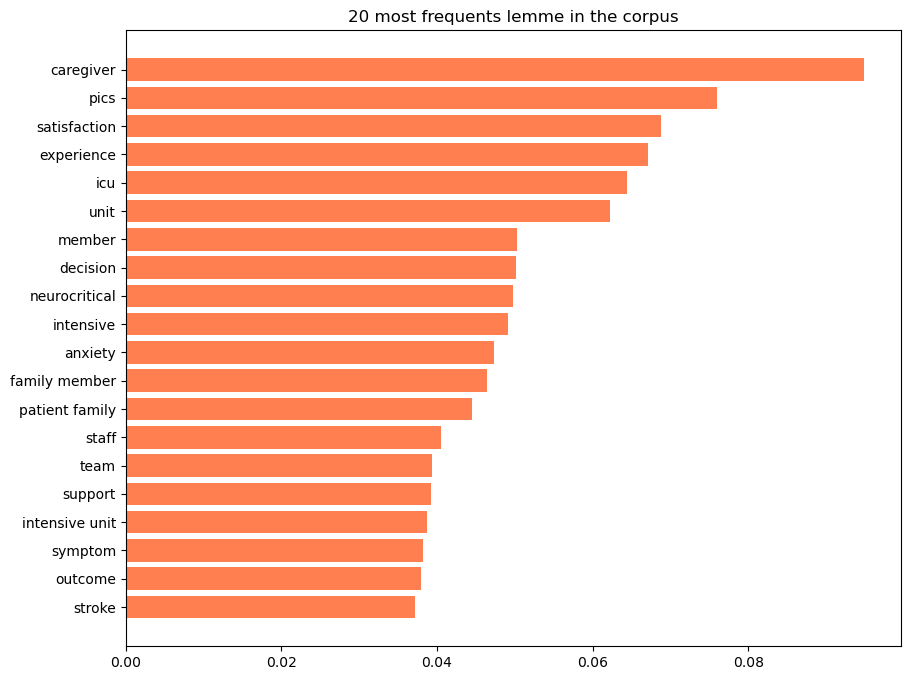

In [10]:
top20 = result.sort_values('score', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(20), top20['score'].values[::-1], color='coral')
plt.yticks(range(20), top20['name'].values[::-1])
plt.title("20 most frequents lemme in the corpus")
plt.show()

I'll try to regroups the abstract by topics using KNN clustering.
There is few abstract in the corpus and we should identify less than 5 topics.

I'll ty to find the optimal cluster number realising  a silhourte score.

   K=2: Score = 0.0296
   K=3: Score = 0.0646
   K=4: Score = 0.0548
   K=5: Score = 0.0542
   K=6: Score = 0.0599
   K=7: Score = 0.0579
Higher silouhette score : K=3 (Score: 0.0646)


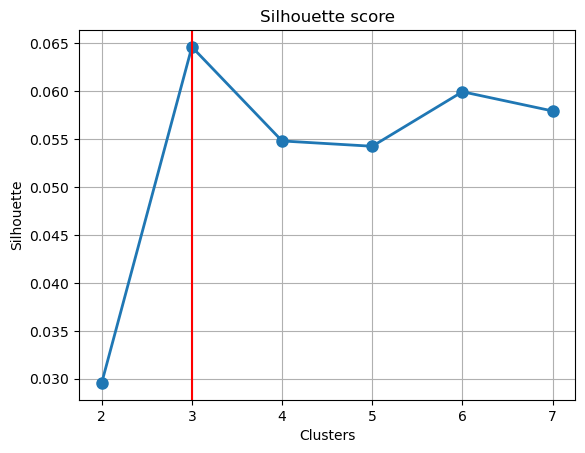

In [11]:
# Tester différents nombres de clusters
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    print(f'   K={k}: Score = {score:.4f}')

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f'Higher silouhette score : K={optimal_k} (Score: {max(silhouette_scores):.4f})')

plt.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8)
plt.axvline(x=optimal_k, color='red')
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.title('Silhouette score')
plt.grid()
plt.show()

In [12]:
## creating the clusters

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X)

print('Abstracts by  cluster:')
print(df['Cluster'].value_counts().sort_index())

Abstracts by  cluster:
Cluster
0    13
1     5
2    18
Name: count, dtype: int64


In [13]:
# Analysis the keyword related to clusters

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(optimal_k):
    print('-' * 60 )
    print(f'Cluster {i} ({len(df[df["Cluster"] == i])} abstracts):')
    keywords = [feature_names[idx] for idx in order_centroids[i, :10]]
    print(f'Related words: {", ".join(keywords)}')

------------------------------------------------------------
Cluster 0 (13 abstracts):
Related words: caregiver, anxiety, symptom, stroke, depression, distress, patient caregiver, palliative, qol, anxiety depression
------------------------------------------------------------
Cluster 1 (5 abstracts):
Related words: pics, survivor, icu, icu survivor, illness, critical, pics pics, review, health, syndrome
------------------------------------------------------------
Cluster 2 (18 abstracts):
Related words: satisfaction, unit, experience, decision, staff, patient family, nurse, neurocritical, involvement, outcome


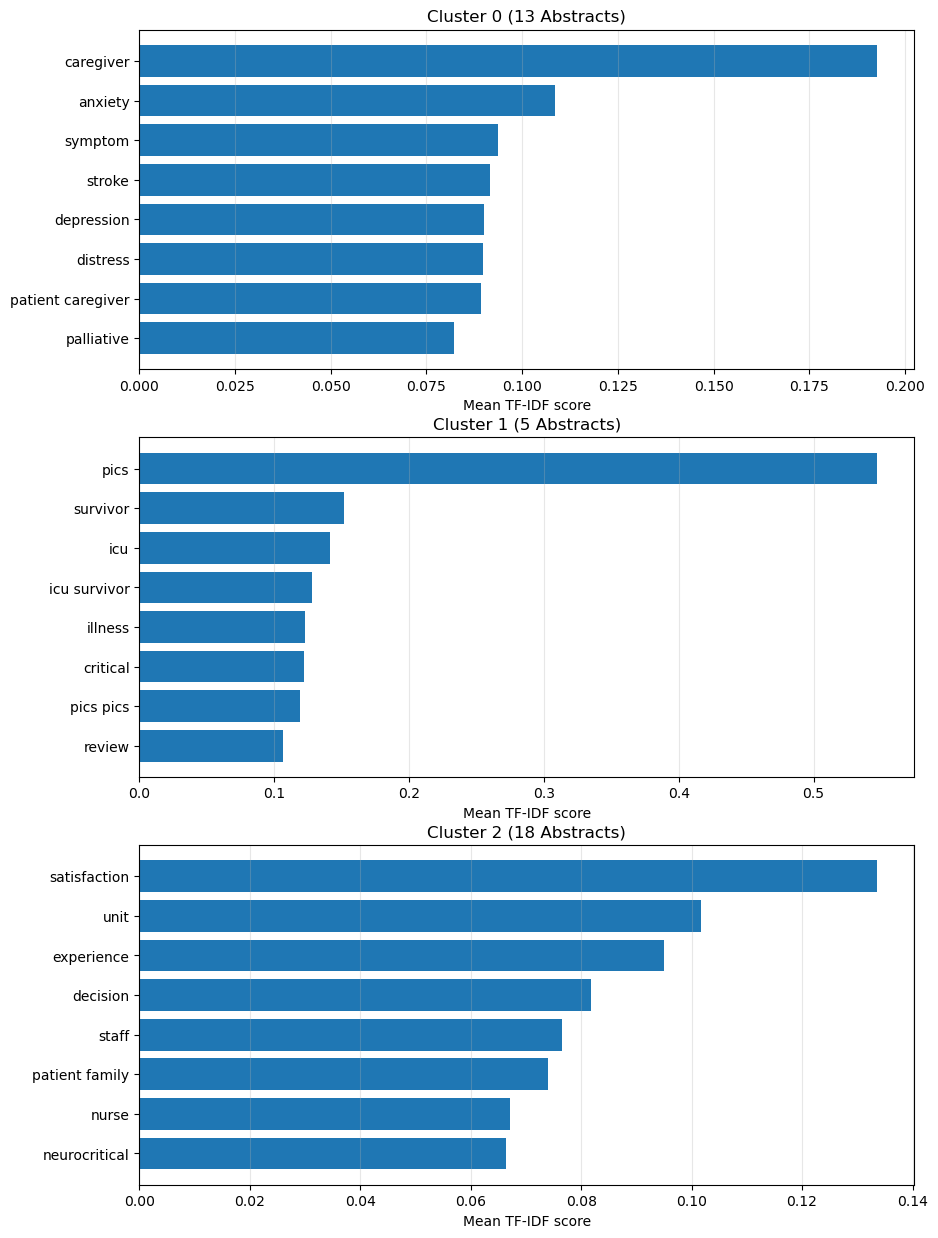

In [14]:

def get_top_terms_per_cluster(X, feature_names, clusters, n_clusters, top_n=8):
    cluster_terms = {}
    
    for i in range(n_clusters):
        cluster_docs = X[clusters == i]
        avg_scores = np.array(cluster_docs.mean(axis=0)).flatten()
        top_indices = avg_scores.argsort()[-top_n:][::-1]
        top_terms = [(feature_names[idx], avg_scores[idx]) for idx in top_indices]
        cluster_terms[i] = top_terms
    return cluster_terms


cluster_terms = get_top_terms_per_cluster(
    X, feature_names, df['Cluster'].values, n_clusters=optimal_k, top_n=8
)

# Créer le graphique
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

for cluster_id in range(optimal_k):
    ax = axes[cluster_id]
    
    # Extraire données
    terms = [t[0] for t in cluster_terms[cluster_id]]
    scores = [t[1] for t in cluster_terms[cluster_id]]
    
    # horizontal bar plot
    y_pos = np.arange(len(terms))
    ax.barh(y_pos, scores[::-1])
    ax.set_yticks(y_pos)
    ax.set_yticklabels(terms[::-1])
    ax.set_xlabel('Mean TF-IDF score')
    
    # Title
    n_docs = len(df[df['Cluster'] == cluster_id])
    ax.set_title(f'Cluster {cluster_id} ({n_docs} Abstracts)')
    ax.grid(axis='x', alpha=0.3)

plt.show()

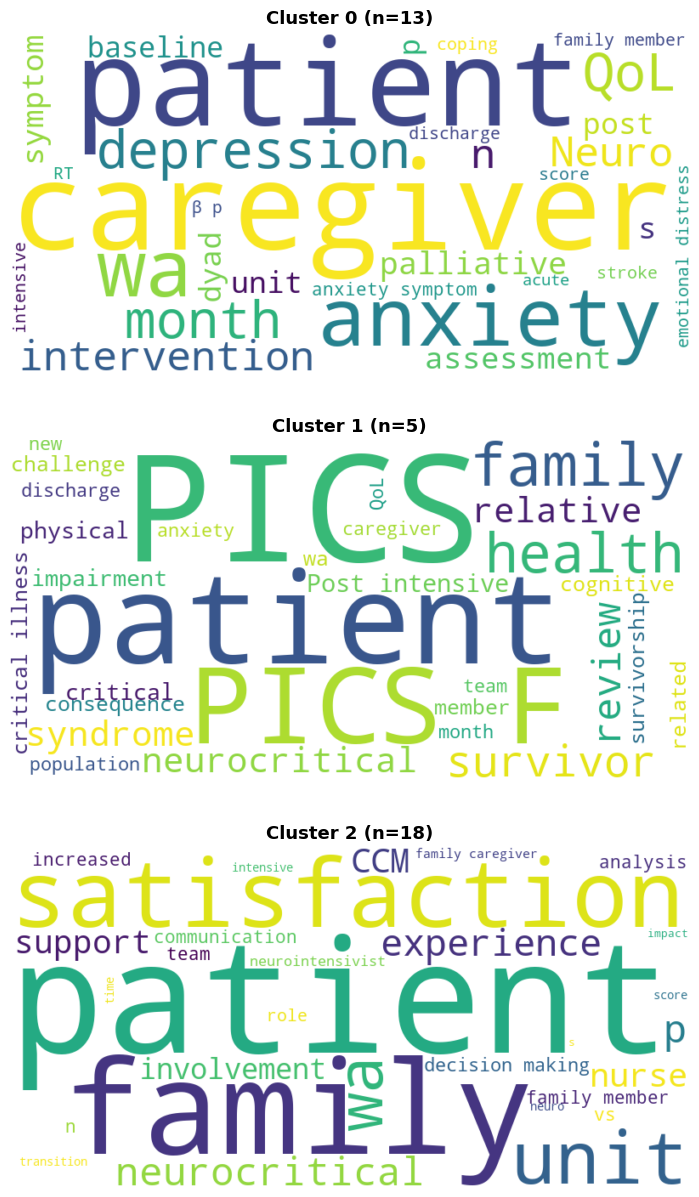

In [15]:
# WordCloud by clusters

n_cols = 1
n_rows = (optimal_k)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if optimal_k > 1 else [axes]

for i in range(optimal_k):
    # join all abstract of the same cluster to had only ione text.
    text = ' '.join(df[df['Cluster'] == i]['Abstract_lem'])
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        stopwords=stop_words,
        max_words=30,
        background_color='white'
    ).generate(text)
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Cluster {i} (n={len(df[df["Cluster"] == i])})', 
                      fontsize=13, fontweight='bold')
    axes[i].axis('off')

# Masquer les axes vides
for i in range(optimal_k, len(axes)):
    axes[i].axis('off')

plt.show()

i'll realize some metadata analysis around the data available:

- Date of publication
- Authorship
- Journal

<Figure size 1400x600 with 0 Axes>

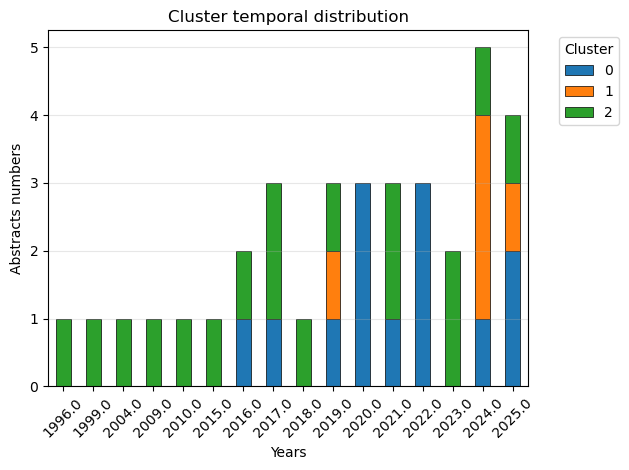

In [16]:
plt.figure(figsize=(14, 6))
    
year_cluster = pd.crosstab(df['Year'], df['Cluster'])
year_cluster.plot(
    kind='bar',
    stacked=True,
    edgecolor='black',
    linewidth=0.5
)
    
plt.title('Cluster temporal distribution')
plt.xlabel('Years')
plt.ylabel('Abstracts numbers')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [17]:

df['Journal'] = df['Journal'].str.strip()
df['Journal'] = df['Journal'].str.lower()


In [18]:

print("Top 10 Journal:")
top_journals = df['Journal'].value_counts().head(10)
for i, (journal, count) in enumerate(top_journals.items(), 1):
    pct = count / len(df) * 100
    print(f"   {i:2d}. {journal[:60]:60s} : {count:2d} articles ({pct:.1f}%)")



Top 10 Journal:
    1. neurocritical care                                           :  7 articles (19.4%)
    2. the journal of neuroscience nursing : journal of the america :  3 articles (8.3%)
    3. cureus                                                       :  2 articles (5.6%)
    4. critical care explorations                                   :  1 articles (2.8%)
    5. medicina intensiva (english edition)                         :  1 articles (2.8%)
    6. clinical nutrition espen                                     :  1 articles (2.8%)
    7. nursing in critical care                                     :  1 articles (2.8%)
    8. chest                                                        :  1 articles (2.8%)
    9. journal of korean neurosurgical society                      :  1 articles (2.8%)
   10. seminars in neurology                                        :  1 articles (2.8%)


In [19]:
journal_cluster = pd.crosstab(df['Journal'], df['Cluster'])

# Garder seulement les journaux avec au moins 2 articles
journal_cluster = journal_cluster[journal_cluster.sum(axis=1) >= 2]

print(f"Journals x clusters ({len(journal_cluster)} more than 2 articles):")
print(journal_cluster.head(10))


Journals x clusters (3 more than 2 articles):
Cluster                                             0  1  2
Journal                                                    
cureus                                              0  0  2
neurocritical care                                  3  1  3
the journal of neuroscience nursing : journal o...  1  0  2


In [20]:
from collections import Counter
all_authors = []
for authors_str in df['Authors'].dropna():
    # separator ";" ou ","
    authors = [a.strip() for a in str(authors_str).replace(';', ',').split(',')]
    all_authors.extend(authors)

author_counts = Counter(all_authors)

print(f"Mean Author/article: {len(all_authors) / len(df):.1f}")

# Top auteurs
print(f"Top 10 Author on this subject:")
for i, (author, count) in enumerate(author_counts.most_common(10), 1):
    if len(author) > 3:  # Éviter les initiales vides
        print(f"   {i:2d}. {author:40s} : {count} articles")


Mean Author/article: 6.2
Top 10 Author on this subject:
    1. Vranceanu Ana-Maria                      : 7 articles
    2. Rosand Jonathan                          : 4 articles
    3. Presciutti Alex                          : 3 articles
    4. Samuels Owen                             : 2 articles
    5. Lin Ann                                  : 2 articles
    6. Zhang Qiang                              : 2 articles
    7. Reichman Mira                            : 2 articles
    8. Muehlschlegel Susanne                    : 2 articles
    9. Kreitzer Natalie                         : 2 articles
   10. Foreman Brandon                          : 2 articles


In [24]:
# try to create a co-author network from metadata

df['Authors list'] = df['Authors'].str.split(';')

In [27]:
all_authors = [author for authors_list in df['Authors list'] for author in authors_list]
n_total_authors = len(all_authors)
n_unique_authors = len(set(all_authors))

print(f"Total number af authors: {n_total_authors}")
print(f"Unique authors: {n_unique_authors}")
print(f"Mean authors/article : {len(all_authors)/len(df):.1f}")

Total number af authors: 223
Unique authors: 208
Mean authors/article : 6.2


In [ ]:
#let's build the graph
import networkx as nx
from itertools import combinations

G = nx.Graph()

for idx, row in df.iterrows():
    authors = row['Authors list']
    
    for author in authors: # Add nodes
        if not G.has_node(author):
            G.add_node(author, publications=0)
        G.nodes[author]['publications'] += 1

    for author1, author2 in combinations(authors, 2):
        if G.has_edge(author1, author2):
            G[author1][author2]['weight'] += 1
        else:
            G.add_edge(author1, author2, weight=1)


print(f"Nodes : {G.number_of_nodes()}")
print(f"EEdges : {G.number_of_edges()}")
print(f"Density : {nx.density(G):.4f}")


Nodes : 208
EEdges : 929
Desnity : 0.0432


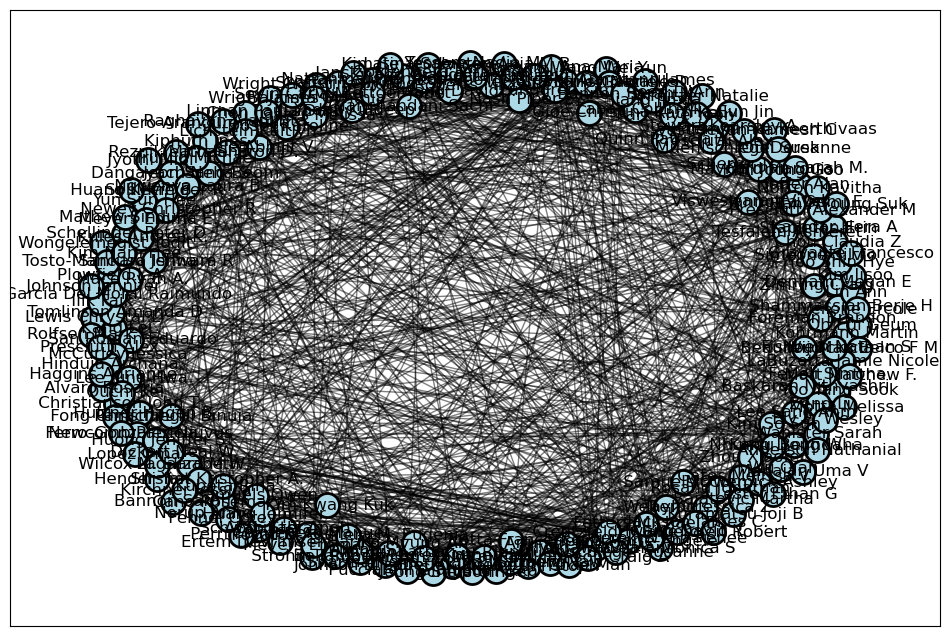

In [56]:
pos = nx.spring_layout(G, k = 4,seed=2, iterations=50)
edge_widths = [G[u][v]['weight'] * 100 for u, v in G.edges()]

fig, ax = plt.subplots(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos,
                       node_color='lightblue', edgecolors='black', 
                       linewidths=2, ax=ax)
nx.draw_networkx_edges(G, pos, 
                       alpha=0.5, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=12, ax=ax)
plt.show()

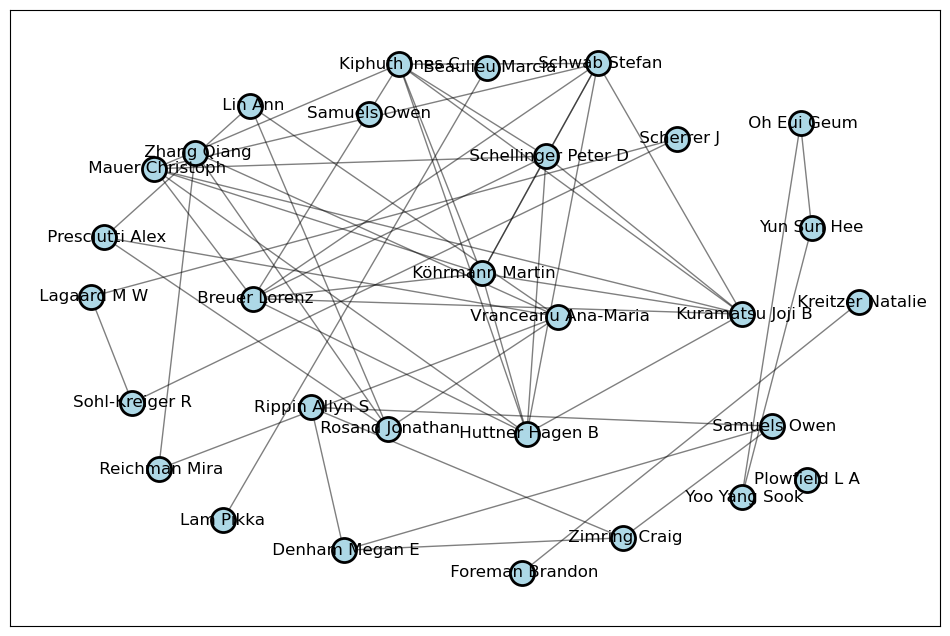

In [67]:
# we must select the top 30 authors to have a readable graph
# creation of a top_authors variable

top_authors_pubs = sorted(G.nodes(data=True), 
                          key=lambda x: x[1]['publications'], 
                          reverse=True)[:50]

top_30_authors = [author for author, _ in top_authors_pubs[:30]]
G_top = G.subgraph(top_30_authors).copy()

pos = nx.spring_layout(G_top, k = 2,seed=2, iterations=50)
edge_widths = [G[u][v]['weight'] * 100 for u, v in G.edges()]

fig, ax = plt.subplots(figsize=(12, 8))
nx.draw_networkx_nodes(G_top, pos,
                       node_color='lightblue', edgecolors='black', 
                       linewidths=2, ax=ax)
nx.draw_networkx_edges(G_top, pos, 
                       alpha=0.5, ax=ax)
nx.draw_networkx_labels(G_top, pos, font_size=12, ax=ax)
plt.show()

In [68]:
from networkx.algorithms import community

# Louvain algorithm pour détection de communautés
communities = community.greedy_modularity_communities(G_top)

# Affichage des communautés
for i, community in enumerate(communities):
    print(f"Communauté {i+1}: {community}")


Communauté 1: frozenset({'Kiphuth Ines C', ' Mauer Christoph', ' Schellinger Peter D', ' Breuer Lorenz', ' Kuramatsu Joji B', ' Schwab Stefan', ' Huttner Hagen B', ' Köhrmann Martin'})
Communauté 2: frozenset({' Presciutti Alex', ' Rosand Jonathan', ' Zhang Qiang', ' Reichman Mira', ' Vranceanu Ana-Maria', ' Lin Ann'})
Communauté 3: frozenset({' Zimring Craig', 'Rippin Allyn S', ' Samuels Owen', ' Denham Megan E'})
Communauté 4: frozenset({' Lagaard M W', ' Scherrer J', 'Sohl-Kreiger R'})
Communauté 5: frozenset({'Yun Sun Hee', ' Oh Eui Geum', ' Yoo Yang Sook'})
Communauté 6: frozenset({' Kreitzer Natalie', ' Foreman Brandon'})
Communauté 7: frozenset({'Lam Pikka', ' Beaulieu Marcia'})
Communauté 8: frozenset({'Samuels Owen'})
Communauté 9: frozenset({'Plowfield L A'})


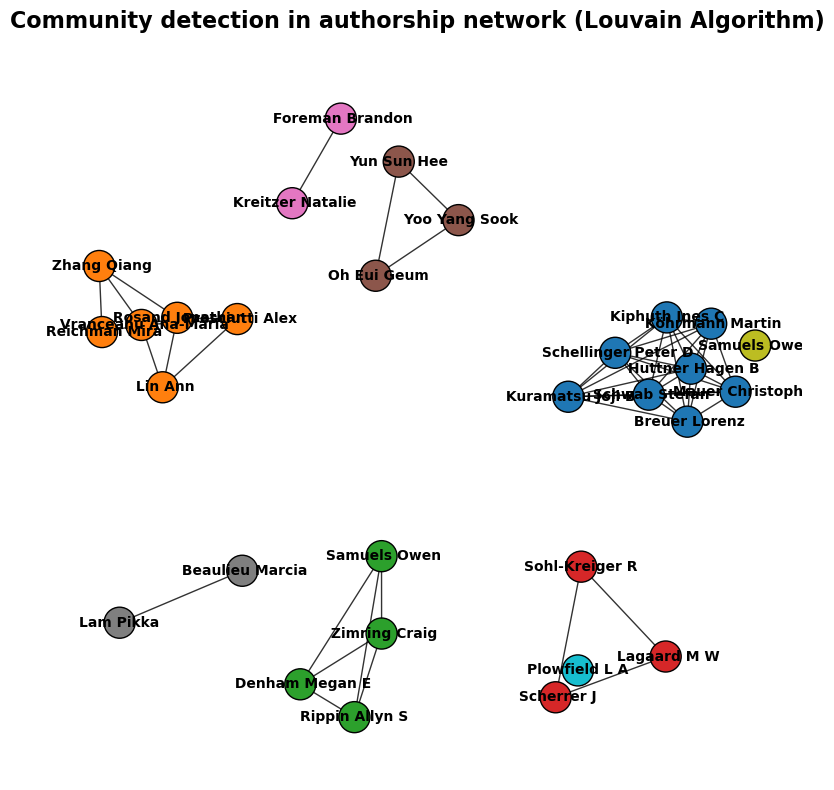

In [86]:
# Générer des couleurs
n_communities = len(communities)
cmap = plt.cm.get_cmap('tab10', n_communities)  # tab10 a 10 couleurs distinctes
community_colors = [cmap(i) for i in range(n_communities)]

# Créer un dictionnaire nœud -> indice de communauté
node_to_color_index = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_to_color_index[node] = i

# Créer la liste des couleurs dans l'ordre des nœuds du graphe
node_colors = []
for node in G_top.nodes():
    # Si le nœud n'est pas dans une communauté (normalement tous le sont), mettre une couleur par défaut
    if node in node_to_color_index:
        node_colors.append(community_colors[node_to_color_index[node]])
    else:
        node_colors.append('gray') 

pos = nx.spring_layout(G_top, seed=42, k=0.7)


fig, ax = plt.subplots(figsize=(8, 8))
nx.draw_networkx_edges(G_top, pos, alpha=0.8, ax=ax)
nx.draw_networkx_nodes(
    G_top, 
    pos,
    node_size=500,
    node_color=node_colors,
    edgecolors='black',
    linewidths=1,
    ax=ax
)

# Dessiner les étiquettes
nx.draw_networkx_labels(
    G_top, 
    pos,
    font_size=10,
    font_weight='bold',
    ax=ax
)


ax.set_axis_off()
plt.title("Community detection in authorship network (Louvain Algorithm)", 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()